# Part 2: 🛠️ Enhancing the Chatbot with Tools¶

- In the above one they can't give the answer from the memory, In below we will integrate web searching tool Our bot can we these tools to get the relevent information and provide better response.

**Requirements**
1. Tavily Search Engine

- Here we have to define TOOLS


In [28]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content="You are a professional news anchor tasked with delivering accurate weather information. "
                    "Maintain a neutral, authoritative tone while presenting meteorological data with clarity. "
                    "Include relevant details such as temperature, humidity, wind speed, and weather conditions."
        ),
        HumanMessage(
            content="Please provide the current weather conditions for Mumbai, India."
        ),
        AIMessage(
            content="Here's the latest weather update for Mumbai: \n\n"
                    "• Current temperature: 32°C (90°F)\n"
                    "• Humidity: 65%\n"
                    "• Wind speed: 15 km/h (ENE)\n"
                    "• Conditions: Partly cloudy with a 20% chance of precipitation\n"
                    "• Updated: [Insert current time] IST"
        ),
        MessagesPlaceholder(variable_name="agent_scratchpad")
    ]
)

In [29]:
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults

load_dotenv()

tool = TavilySearchResults(max_results= 2)

tools = [tool]

# tool.invoke("what is the current weather of mumbai.")

- All things will be same as part one but except `bind_tool` on our **LLM** we have to bind TavilySearch with llm 

In [30]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain.prompts import ChatPromptTemplate
from langchain.agents import AgentExecutor,create_openai_tools_agent,AgentType

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")

# llm_with_tools = llm.bind_tools(tools)
agent = create_openai_tools_agent(llm=llm,tools=tools,prompt=prompt)

agent_executor = AgentExecutor(agent=agent,tools=tools)

def chatbot(state:State):
    messages = state["messages"]
    response = agent_executor.invoke(messages)
    return {"messages": [response]}

graph_builder.add_node("chatbot", chatbot)

Next we need a function that run the actual tool if they are called.

- `BasicToolNode` that checks the most recent message in the state. Check if that message contains tool_call we call the give tool. it relies on the LLM'S tool_calling support.

In [31]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""
    def __init__(self, tools:list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    # It make the object to be callable like a function
    # greeter = Greeeter() --> print(greeter("Alice")) --> automatically call the __call__ function with the give args.
    def __call__(self, input: dict):
        if messages := input.get("messages",[]):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        outputs = []

        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(tool_call["args"])

            outputs.append(
                ToolMessage(
                    content = json.dumps(tool_result),
                    name = tool_call["name"],
                    tool_call_id = tool_call["id"]
                )
            )

        return {"messages" : outputs}

tool_node = BasicToolNode(tools = tools)

graph_builder.add_node("tools",tool_node)

- ##### After Adding node we add `conditional_edge`.
- Key components
1. In the previous one we know about edge that call the nodes based on previous state.
2. In the blow one we do same thing check if the current state have tool_calls than we call the node of tools else we end it.
* `Notice` when we add `add_conditional_edges` function we recieve the current graph `state` and return string or list of string indicating which node(s) to call next.

In [ ]:
def route_tools(state: State):
    """
        Use in the conditional_edge to route to the ToolNode if the last message
        has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages",[]):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No message found in input state to tool_edge: {state}")
    
    if hasattr(ai_message,"tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    {"tools":"tools",END:END}
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

NameError: name 'State' is not defined

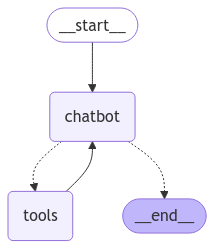

In [33]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
   pass 

In [ ]:
from langchain_core.messages import HumanMessage

def stream_graph_updates(user_input: str):
    for events in graph.stream({"messages":user_input}):
        for value in events.values():
            if "messages" in value:
                print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")

        if user_input.lower() in ["quit","q","exit"]:
            print("Goodbye!")
            break
        print("User: " + user_input)
        stream_graph_updates(user_input)
    except:
        user_input = "What do you know about langgraph."
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: what is current weather of mumbai.
User: What do you know about langgraph.


IndexError: list index out of range